In [1]:
# Import libraries
import pickle
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

## Make test sample and example classes from Brazil dataset

In [ ]:
img_brazil = xr.open_zarr('../../../data/Fieldwork_data/brazil_cutouts_labels.zarr')
img_brazil

In [ ]:
test_sample_brazil = img_brazil.isel(sample=0)
test_sample_brazil = test_sample_brazil.drop_vars('Y')
test_sample_brazil

In [ ]:
# Visualize the test sample
test_sample_brazil['X'].astype('int').plot.imshow()

In [ ]:
test_sample_brazil.to_zarr('test_example_brazil.zarr', mode='w')

In [ ]:
example_classes_brazil = img_brazil.isel(sample=range(1,7))
name = 'palmtree'
attr = {'description': name, 'source': 'orthomosaic image from field survey'}
example_classes_brazil.attrs = attr
example_classes_brazil = example_classes_brazil.drop_vars('Y')
example_classes_brazil

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
for i, ax in enumerate(axes.flat):
    example_classes_brazil.isel(sample=i)['X'].astype('int').plot.imshow(ax=ax)
    ax.set_title(f"True class: {name}")

In [ ]:
example_classes_brazil.to_zarr(f'class_{name}.zarr', mode='w')

## Make example classes from reforesttree dataset

In [ ]:
# Individual cut-out of trees extracted from reforestree dataset
# Padding black borders to 400x400 pixels
imdata = xr.open_zarr('../../../data/reforestree/processed/foresttree.zarr/')
imdata

In [ ]:
# Load training data
# These are the pairs of images made from imdata
pairs = xr.open_zarr('../../../data/reforestree/processed/training_data.zarr')
pairs

In [ ]:
# Get index of images used for training
# These are also idx in imdata
idx = np.unique(pairs['index_pair'].values)
print(idx)
print(idx.shape)

In [ ]:
# Select images used for training
imgs = imdata.sel(sample=idx)
imgs

In [ ]:
# Split imgs by class
classes =  np.unique(imgs.Y.values)
class_data = {}
for class_i in classes:
    class_data[class_i] = imgs.where(imgs.Y.compute()==class_i, drop=True)

In [ ]:
class_data

### Modify classes and save

In [ ]:
class_map = {1: 'banana', 2: 'cacao', 4:'fruit'}

for id, name in class_map.items():
    ds = class_data[id]
    ds = ds.drop_vars('Y')
    attr = {'description': name, 'source': 'https://github.com/gyrrei/ReforesTree'}
    ds.attrs = attr
    ds.to_zarr(f'class_{name}.zarr', mode='w')

## Prepare training data for SVM classifier

Take reforesttree dataset not involved into the Siamese network training and make training data for SVM classifier.

In [12]:
# Select images NOT used for training
imdata = xr.open_zarr('../../../data/reforestree/processed/foresttree.zarr/')
pairs = xr.open_zarr('../../../data/reforestree/processed/training_data.zarr')
idx = np.unique(pairs['index_pair'].values)

imgs = imdata.drop_sel(sample=idx)
imgs

<xarray.Dataset>
Dimensions:  (sample: 1882, x: 400, y: 400, channel: 3)
Dimensions without coordinates: sample, x, y, channel
Data variables:
    X        (sample, x, y, channel) float32 dask.array<chunksize=(1, 400, 400, 3), meta=np.ndarray>
    Y        (sample) int64 dask.array<chunksize=(1,), meta=np.ndarray>

In [14]:
# Get 50 samples of each class (ONLY 1 and 2 available for now)
imgs1 = imgs.where((imgs.Y==1).compute(), drop=True).isel(sample=range(50))
imgs1['Y'] = imgs1['Y']-1
imgs2 = imgs.where((imgs.Y==2).compute(), drop=True).isel(sample=range(50))
imgs2['Y'] = imgs2['Y']-1
imgs_subset = xr.concat([imgs1, imgs2], dim='sample')
attr = {
    "class_map": {0: "banana", 1: "cacao"},
    "source": "https://github.com/gyrrei/ReforesTree",
}
imgs_subset.attrs = attr
imgs_subset

<xarray.Dataset>
Dimensions:  (sample: 100, x: 400, y: 400, channel: 3)
Dimensions without coordinates: sample, x, y, channel
Data variables:
    X        (sample, x, y, channel) float32 dask.array<chunksize=(1, 400, 400, 3), meta=np.ndarray>
    Y        (sample) float64 dask.array<chunksize=(1,), meta=np.ndarray>
Attributes:
    class_map:  {0: 'banana', 1: 'cacao'}
    source:     https://github.com/gyrrei/ReforesTree

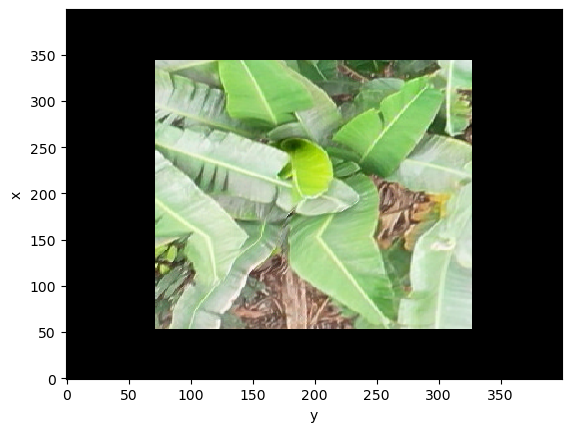

In [17]:
imgs_subset['X'].isel(sample=0).astype('int').plot.imshow()

In [18]:
imgs_subset.to_zarr('svm_training_data.zarr', mode='w')